# Importing Necessary Libruaries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Import Data and Formatting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/PA2/SalesD.txt'
df = pd.read_csv(path)
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    204 non-null    object 
 1   value   204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


Here, 'date' variable should be converted to date-time format before plotting the data.

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

Plotting Time Series Data

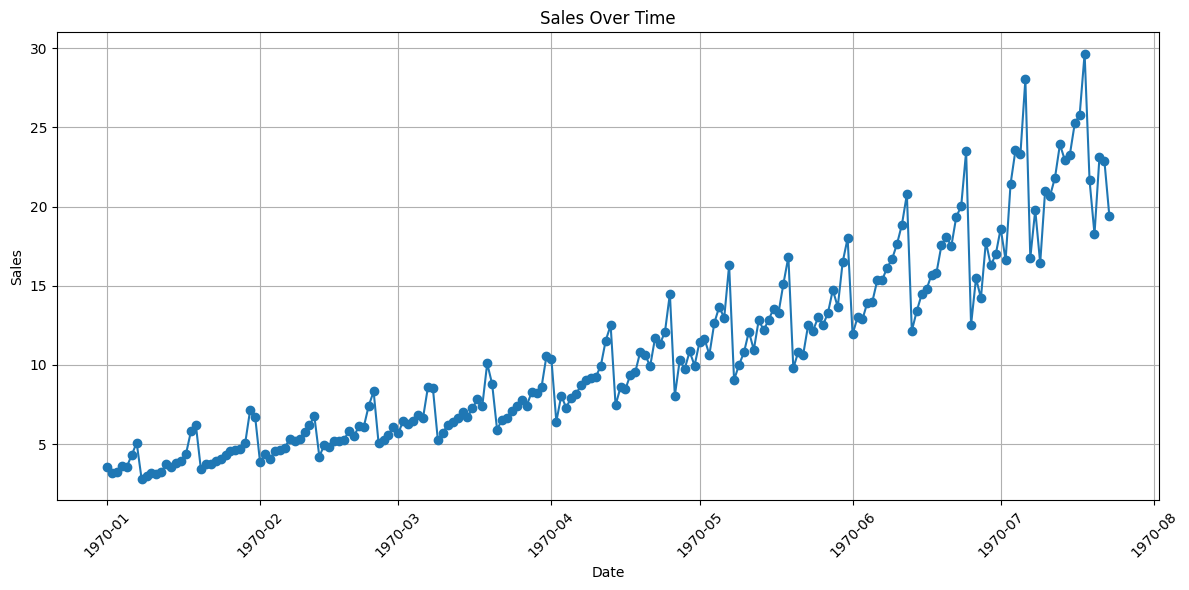

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(12, 6))
df['value'].plot(marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The time series plot illustrates the sales trend over the observed period. There appears to be a general upward trend in sales, although with some fluctuations. Also, according to the time series plot, sales data is not stationary with respect to mean and variance.

# Stationary of the time series data

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


Hypothesis of Stationary test
Null hypothesis : Data series is stationary
Alternative hypothesis : Data series is not stationary

P value is 1 which is greater than the significance level(0.05). Hence, Null hypothesis is rejected.

Before going to the further analysis, It is required to make the data series stationary.

# Make the series stationary

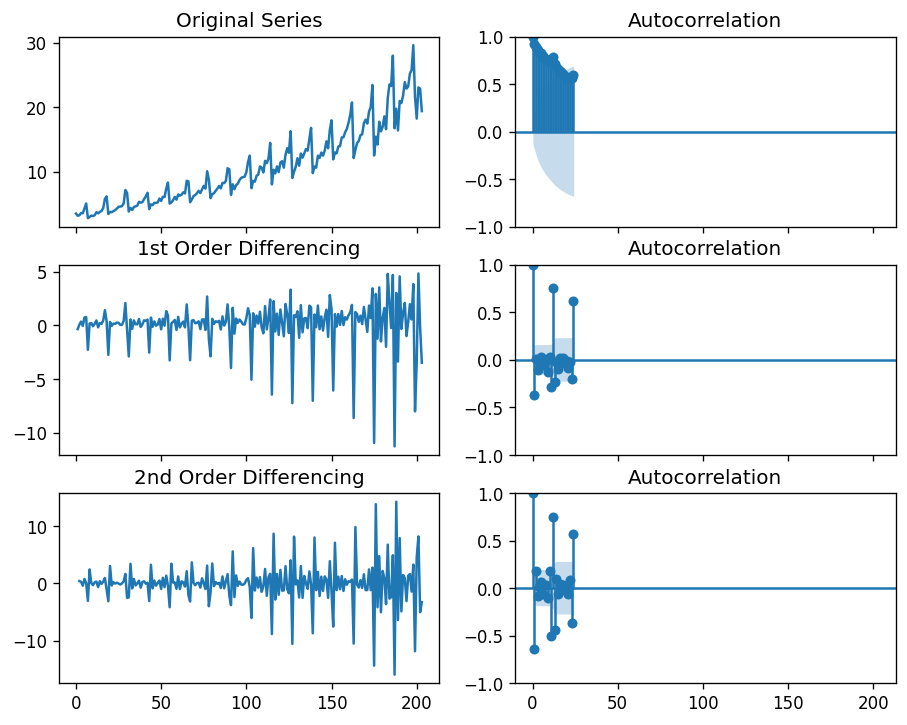

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Differencing techniques applied to make the sales data into stationary. According to the second order defferencing graph, our series became stationary. Lets check this with ADF test.

Confirming the stationarity of the series

In [ ]:
# Calculating the first-order difference
diff_series = df.value.diff().dropna()

# Run the ADF test
result = adfuller(diff_series)

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])



ADF Statistic: -2.4951721474497393
p-value: 0.11665341686468789


According to the P-value, series is not still stationary, lets try the second differencing.

In [ ]:
# Calculating the second-order difference
diff_series_2 = df.value.diff().diff().dropna()

# Run the ADF test
result = adfuller(diff_series_2)

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -10.29230470651732
p-value: 3.543916358529341e-18


According to the P-value, series is stationary.

# Finding the order of the AR term (p)

Here, the required number of AR terms will find by inspecting the **Partial Autocorrelation (PACF) plot**.

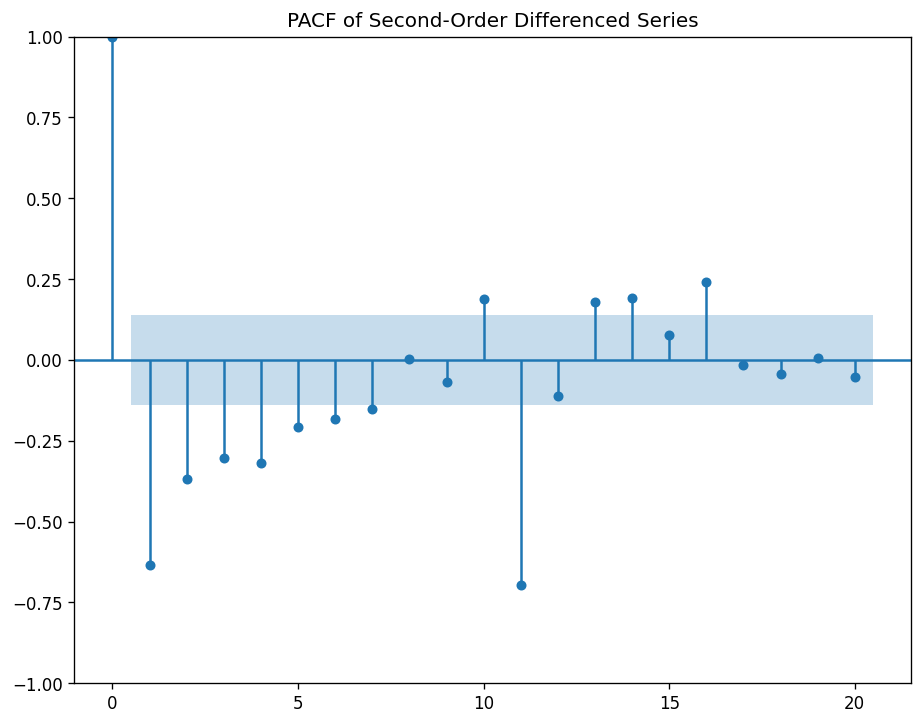

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Calculating the second-order difference
diff_series_2 = df.value.diff().diff().dropna()

# Plot the PACF
plot_pacf(diff_series_2, lags=20)
plt.title('PACF of Second-Order Differenced Series')
plt.show()

According to the PACF, spikes of 1, 2, 3, 4,5, and 6 extended beyond the significant confidence interval, hence, the possible values for p are 1,2,3,4,5,6.

# Finding the order of the MA term (q)

Here, the required number of AR terms will find by inspecting the **Autocorrelation Function (ACF) plot**.

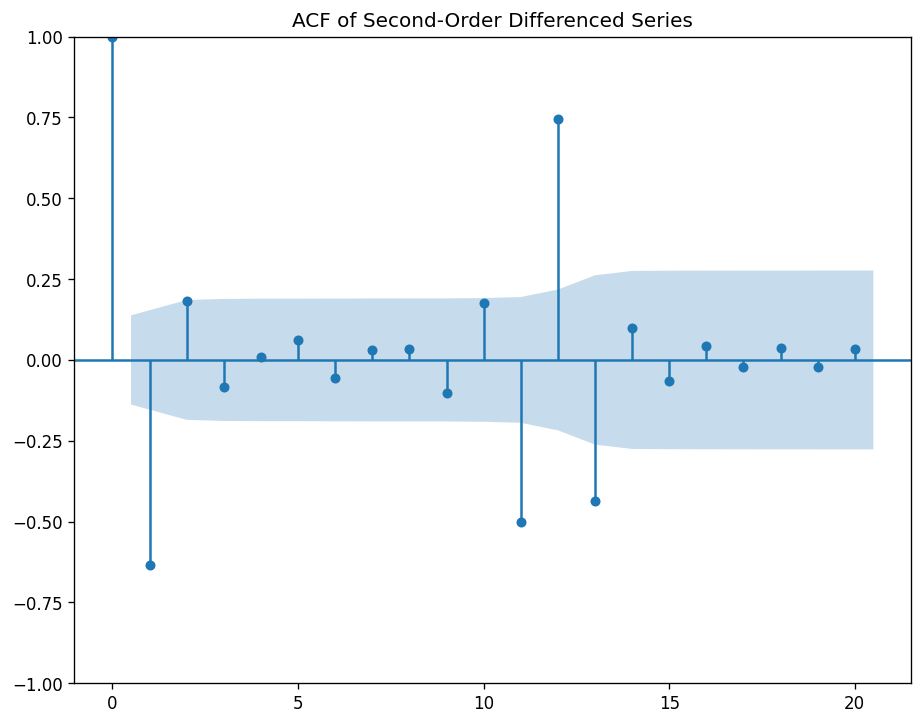

In [ ]:
# Plot the ACF
plot_acf(diff_series_2, lags=20)
plt.title('ACF of Second-Order Differenced Series')
plt.show()

According to the ACF, 1, 11, 12 and 13 spike are significant. When we considering the non-seasonal q values, then, q=1.  11th, 12th and 13th significant spikes are related to easonality. So, we might consider using a Seasonal ARIMA (SARIMA) model. Here, I considered only the non-seasonal ARIMA.

# Building the ARIMA Model

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

y = df['value']

d = 2
q = 1


for p in [1, 2, 3, 4, 5, 6]:

    model = sm.tsa.ARIMA(y, order=(p, d, q))
    model_fit = model.fit()


    print(f"ARIMA({p}, {d}, {q}) Model Summary:")
    print(model_fit.summary())
    print("\n" + "="*50 + "\n")

ARIMA(1, 2, 1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -438.108
Date:                Sat, 02 Nov 2024   AIC                            882.216
Time:                        00:18:20   BIC                            892.141
Sample:                             0   HQIC                           886.232
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3649      0.054     -6.780      0.000      -0.470      -0.259
ma.L1         -0.9998      1.594     -0.627      0.531      -4.124       2.125
sigma2         4.3480 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(6, 2, 1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(6, 2, 1)   Log Likelihood                -428.096
Date:                Sat, 02 Nov 2024   AIC                            872.193
Time:                        00:18:23   BIC                            898.659
Sample:                             0   HQIC                           882.901
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5047      0.059     -8.499      0.000      -0.621      -0.388
ar.L2         -0.3117      0.086     -3.619      0.000      -0.481      -0.143
ar.L3         -0.3033 

According to the results best model for the data set is ARIMA(6, 2, 1). Because it has lower AIC

According to the results, coefficients of AR(1,2,3,4)are statistically significant.
Null hypothesis: Coefficient is not statistically significant
Alternative hypothesis: Coefficient is statistically significant

Hence, ARIMA model with (4,2,0)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df.value, order=(4,2,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -461.776
Date:                Sat, 02 Nov 2024   AIC                            933.553
Time:                        00:18:37   BIC                            950.094
Sample:                             0   HQIC                           940.246
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0941      0.071    -15.345      0.000      -1.234      -0.954
ar.L2         -0.8680      0.094     -9.243      0.000      -1.052      -0.684
ar.L3         -0.6484      0.095     -6.823      0.0

# Model Accuracy Checking

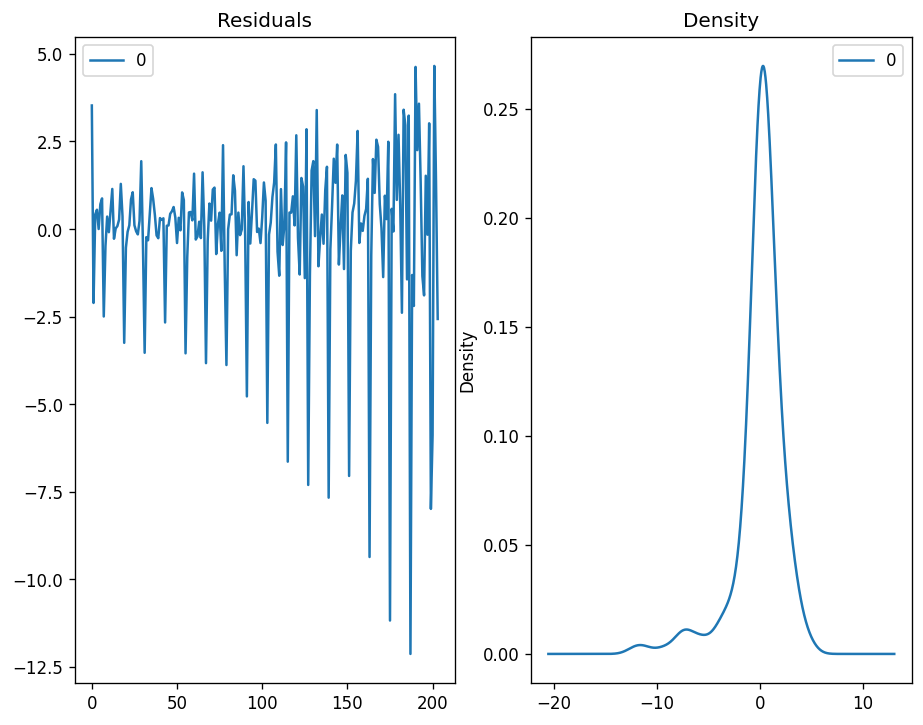

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

Plot of the actuals against the fitted values.

In [ ]:
# Get the fitted values and actual values
fitted_values = model.fit()
actual_values = df['value']

In [ ]:
model_fit = model.fit()
fitted_values = model_fit.predict() # fitted values
actual_values = df['value']

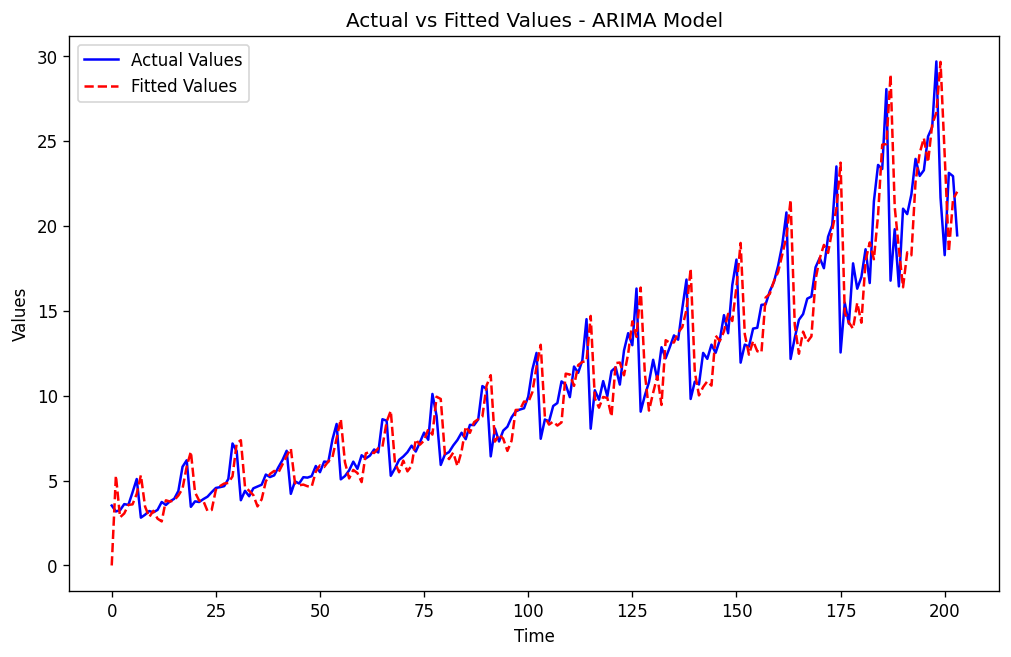

In [ ]:
# Plot actual and fitted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label="Actual Values", color='blue')
plt.plot(fitted_values, label="Fitted Values", color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Actual vs Fitted Values - ARIMA Model")
plt.legend()
plt.show()

So, we seem to have a decent ARIMA model because both graphs are tallied perfectly. But, we can’t say that this is the best ARIMA model because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation can be done by cross-validation.

# Find the optimal ARIMA model using Cross validation

In cross-validation, it moves backwards in time and forecast into the future to as many. Then,  comparison can be done with the forecast against the actuals.

To do so, data set will be divided in to the training and testing sets by splitting the time series into 2 contiguous parts in a reasonable proportion based on time frequency of series.

In [ ]:
# split index
split_index = int(0.8 * len(df))

# Split the data
train = df.value[:split_index]
test = df.value[split_index:]

print(f"Training data size: {len(train)}")
print(f"Testing data size: {len(test)}")

Training data size: 163
Testing data size: 41


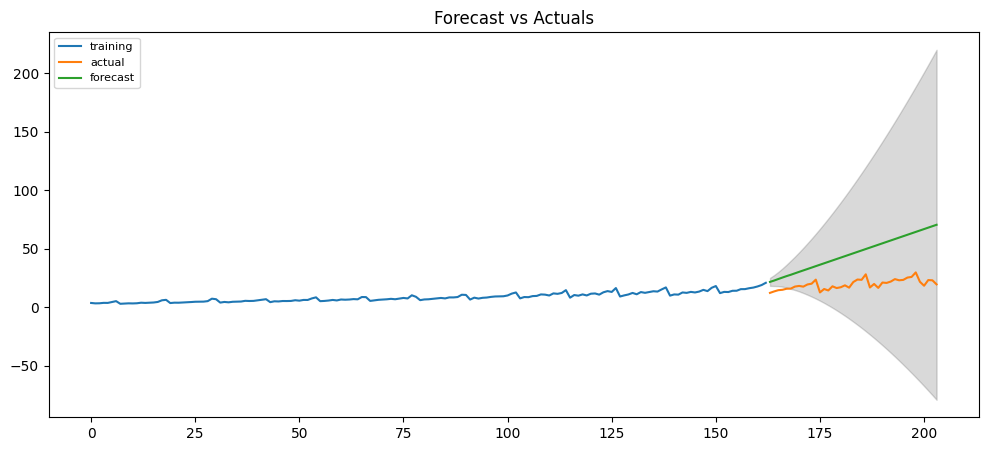

In [ ]:
# Now, build the ARIMA model on training dataset, forecast and plot.

model = ARIMA(train, order=(4, 2, 0))
fitted = model.fit()

# Forecast
fc = fitted.forecast(119)
# getting confidence intervals
forecast = fitted.get_forecast(steps=119)
conf = forecast.conf_int(alpha=0.05)
se = forecast.se_mean

# Make as series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the above chart, the ARIMA(4,2,0) model seems to predict a correct forecast. The actual observed values lie within the 95% confidence band.

